# Imperfect HWP simulation

In [8]:
import numpy as np
import os
import sys

# Add local python/ folder to path for imports
sys.path.insert(0, '../../python/')
import instrument_mm

# -----------------------------
# Fixed parameters
# -----------------------------
observer_latitude = 20.0
observer_longitude = -155.5
targets = [{"name": "Hamal", "ra": 31.791, "dec": 23.462}]

observation_date = "2460614.91667"  # JD date
observation_time = "10:00:00"       # UT time

t_int = 60          # integration time in seconds (1 min)
sub_tint = 1        # sub integration time (1 sec)
num_samples = 100   # number of sampled steps

DoLP = 0.01                         # injected DoLP (1%)
AoLP_values = np.arange(0, 181, 20) # sweep AoLP from 0 to 180 deg

matrix_noise = 5            # injected matrix noise (percent units)
matrix_noise_type = "additive"
HWP_noise = 0
delta_HWP = 0.5             # HWP retardance (in waves)
num_trials = 50             # number of trials per AoLP
noise_percentage = 0        # intensity noise fraction

# -----------------------------
# Helper: convert DoLP & AoLP → Stokes Q, U
# -----------------------------
def aolp_to_stokes(dolp, aolp_deg):
    a = np.radians(aolp_deg)
    Q = dolp * np.cos(2*a)
    U = dolp * np.sin(2*a)
    return Q, U

# -----------------------------
# Set up output .txt file
# -----------------------------
notebook_name = os.path.splitext(os.path.basename(__file__))[0] if '__file__' in globals() else 'HWP_DoLP_residuals_matrix_noise_0.05_DoLP_0.01_varying_AoLP.ipynb'
output_dir = "../numpy_files"
os.makedirs(output_dir, exist_ok=True)
txt_path = os.path.join(output_dir, notebook_name + ".txt")

# Write header line
with open(txt_path, "w") as f:
    f.write("aolp_deg, mean_residual, std_residual, target_name, target_ra, target_dec\n")

    # -----------------------------
    # Loop over targets and AoLP values
    # -----------------------------
    for target in targets:
        for aolp in AoLP_values:
            Q_inj, U_inj = aolp_to_stokes(DoLP, aolp)
            residuals = []

            # Repeat many trials to capture scatter
            for _ in range(num_trials):
                S_in_retrieved = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                    ra=target["ra"], dec=target["dec"],
                    observer_latitude=observer_latitude, observer_longitude=observer_longitude,
                    jd_str=observation_date, ut_start=observation_time,
                    t_int=t_int, Q=Q_inj, U=U_inj, delta_HWP=delta_HWP,
                    noise_percentage=noise_percentage, 
                    include_V=False,
                    sub_tint=sub_tint,
                    TMT_matrix_noise=matrix_noise,
                    NFIRAOS_matrix_noise=matrix_noise,
                    MODHIS_matrix_noise=matrix_noise,
                    observable="intensities",
                    sampled_steps=num_samples,
                    matrix_noise_type=matrix_noise_type,
                    HWP_noise=HWP_noise,
                    normalize_s_out=True
                )

                # Extract retrieved Q,U and compute polarization amplitude
                Q_ret, U_ret = S_in_retrieved[1], S_in_retrieved[2]
                residuals.append(abs(np.hypot(Q_inj, U_inj) - np.hypot(Q_ret, U_ret)))

            # Write mean ± std of residuals for this AoLP to file
            f.write(f"{aolp}, {np.mean(residuals):.8f}, {np.std(residuals):.8f}, {target['name']}, {target['ra']}, {target['dec']}\n")

print(f"Saved summary data to {txt_path}")


Normalized inverted_s_in: [1.00000000e+00 9.50068288e-03 4.61453749e-04]
Normalized inverted_s_in: [1.00000000e+00 9.37073350e-03 3.96623827e-05]
Normalized inverted_s_in: [ 1.00000000e+00  9.42165859e-03 -1.42131328e-04]
Normalized inverted_s_in: [1.         0.00915983 0.00164745]
Normalized inverted_s_in: [1.00000000e+00 9.57411154e-03 3.03041638e-04]
Normalized inverted_s_in: [1.00000000e+00 1.30179552e-02 5.06335103e-04]
Normalized inverted_s_in: [ 1.00000000e+00  1.01063013e-02 -2.90170759e-04]
Normalized inverted_s_in: [1.00000000e+00 9.09468934e-03 7.41477526e-05]
Normalized inverted_s_in: [ 1.00000000e+00  1.00163451e-02 -1.25084864e-04]
Normalized inverted_s_in: [1.00000000e+00 9.79430634e-03 8.44298089e-05]
Normalized inverted_s_in: [1.00000000e+00 8.73530554e-03 1.26659794e-04]
Normalized inverted_s_in: [ 1.          0.00902153 -0.00101773]
Normalized inverted_s_in: [1.         0.00824826 0.0015269 ]
Normalized inverted_s_in: [1.00000000e+00 1.01461592e-02 8.79822649e-04]
No

# Regenerating Plots

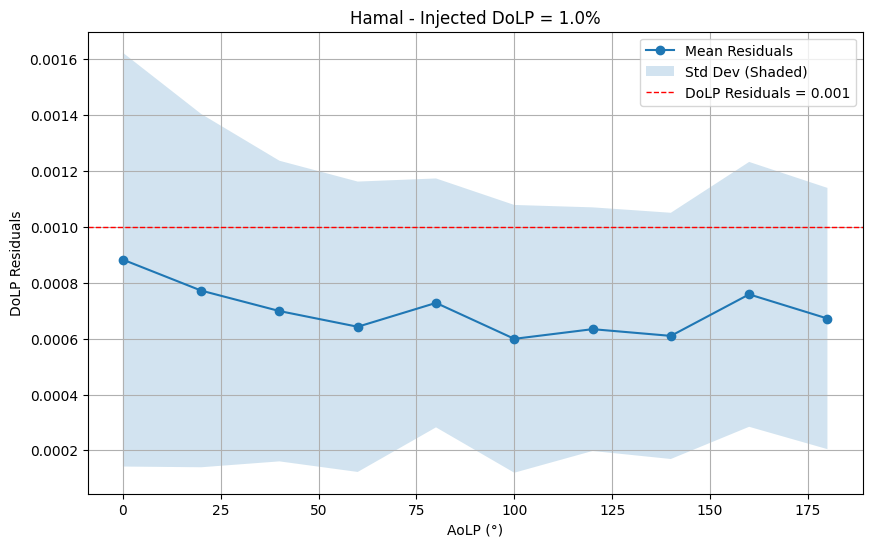

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

# -----------------------------
# Define the targets to plot
# -----------------------------
targets = [{"name": "Hamal", "ra": 31.791, "dec": 23.462}]

# Path to saved .txt file (adjust if needed)
txt_path = "../numpy_files/HWP_DoLP_residuals_varying_matrix_noise_0.05_DoLP_0.01_varying_AoLP.txt"

DoLP = 0.01

# -----------------------------
# Read data from .txt file
# -----------------------------
data = []
with open(txt_path, "r") as f:
    header = f.readline()  # skip header line
    for line in f:
        parts = line.strip().split(",")
        if len(parts) < 6:
            continue
        aolp = float(parts[0])
        mean_residual = float(parts[1])
        std_residual = float(parts[2])
        target_name = parts[3].strip()
        target_ra = float(parts[4])
        target_dec = float(parts[5])
        data.append((aolp, mean_residual, std_residual, target_name, target_ra, target_dec))
data = np.array(data, dtype=object)

# -----------------------------
# Plot for each target
# -----------------------------
for target in targets:
    # Mask rows belonging to this target
    mask = data[:,3] == target['name']
    aolp_vals = data[mask,0].astype(float)
    mean_residuals = data[mask,1].astype(float)
    std_residuals = data[mask,2].astype(float)

    plt.figure(figsize=(10,6))
    # Mean residuals vs AoLP
    plt.plot(aolp_vals, mean_residuals, '-o', label="Mean Residuals")
    # Shaded region ±1σ
    plt.fill_between(aolp_vals,
                     mean_residuals-std_residuals,
                     mean_residuals+std_residuals,
                     alpha=0.2, label="Std Dev (Shaded)")

    # Add dashed horizontal line at DoLP = 0.001
    plt.axhline(0.001, color='red', linestyle='--', linewidth=1, label="DoLP Residuals = 0.001")

    plt.xlabel("AoLP (°)")
    plt.ylabel("DoLP Residuals")
    plt.title(f"{target['name']} - Injected DoLP = {DoLP*100:.1f}%")
    plt.grid(True)
    plt.legend()
    plt.show()
